In [5]:
import yaml
import time
from datetime import datetime
from megadetector.detection import run_detector
import pandas as pd

import sys
sys.path.append('../scripts')  # Adjust the path as needed to point to the directory containing utils.py

from alert_utils import detector, classifier, set_device, check_emails, extract_and_update_camera_info, update_camera_data_dataframe, batch_classification

In [6]:
# Load settings from configuration file
with open('../config.yaml') as file:
    config = yaml.safe_load(file)

IMAP_HOST = config['imap_config']['host']
EMAIL_USER = config['imap_config']['user']
EMAIL_PASS = config['imap_config']['password']
TELEGRAM_BOT_TOKEN = config['telegram_config']['bot_token']
TELEGRAM_CHAT_ID = '-1002249589791' # replace with config after tests

# Detection and Classification Model Settings
DETECTOR_MODEL_PATH = '../models/md_v5a.0.0.pt'
DETECTOR_CLASSES = ["animal", "human", "vehicle"]
DETECTION_THRESHOLD = 0.10

BACKBONE = 'vit_large_patch14_dinov2'
CLASSIFIER_MODEL_PATH = '../models/deepfaune-vit_large_patch14_dinov2.lvd142m.pt'
CLASSIFIER_CLASSES = ["badger", "ibex", "red deer", "chamois", "cat", "goat", "roe deer", "dog", "squirrel", "equid", "genet", "hedgehog", "lagomorph", "wolf", "lynx", "marmot", "micromammal", "mouflon", "sheep", "mustelid", "bird", "bear", "nutria", "fox", "wild boar", "cow"]
CLASSIFICATION_THRESHOLD = 0.20

species_of_interest = {"wild boar", "bear", "wolf", "roe deer", "red deer"}
CAPTURE_DATABASE_PATH = '../data/capture_database.csv'
CAMERA_LOCATIONS_PATH = '../data/camera_locations.csv'


# Initialise the Detection and Classifier Models
device = set_device()
detector_model = run_detector.load_detector(DETECTOR_MODEL_PATH)
print("Loading classifier...")
start_time = time.time()
classifier_model = classifier(CLASSIFIER_MODEL_PATH, BACKBONE, CLASSIFIER_CLASSES, device)
end_time = time.time()
print(f"Loaded classifier in {(end_time - start_time):.2f} seconds")

Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


Loaded model in 0.42 seconds
Loading classifier...
Loaded classifier in 3.81 seconds


Monitoring fcccameratraps@gmail.com for new messages...

Email Received.
Images: 1, Camera ID: CC044C, Camera Make: UOVision
Date: 2024-05-29, Time: 22:52:32, Temperature: 13
Battery: 100%, SD Memory: 99%
Location: Piscul Lat, GPS: X: 25.01059634, Y: 45.326467, Z: 861m, Map URL: https://maps.app.goo.gl/3g6QH2rn6Qw7Aema6
Image 1: Animal Count = 1, Human Count = 0, Vehicle Count = 0
Image 1, Detection 1 (0.728 confidence), Species: badger (58.43% confidence)



Email Received.
Images: 1, Camera ID: CC044C, Camera Make: UOVision
Date: 2024-05-31, Time: 23:12:54, Temperature: 17
Battery: 100%, SD Memory: 98%
Location: Piscul Lat, GPS: X: 25.01059634, Y: 45.326467, Z: 861m, Map URL: https://maps.app.goo.gl/3g6QH2rn6Qw7Aema6
Image 1: Animal Count = 1, Human Count = 0, Vehicle Count = 0
Image 1, Detection 1 (0.719 confidence), Species: badger (99.83% confidence)


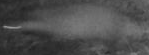


Email Received.
Images: 0, Camera ID: WILDBOAR02, Camera Make: Wilsus
Date: 2024-05-31, Time: 17:02:09, Temperature: 22
Battery: 100%, SD Memory: 99%
Location: Piscul Lat, GPS: X: 25.01059634, Y: 45.326467, Z: 862m, Map URL: https://maps.app.goo.gl/3g6QH2rn6Qw7Aema6
Interrupted by user


In [7]:
if __name__ == "__main__":
    print(f"Monitoring {EMAIL_USER} for new messages...")
    while True:
        try:
            images, camera_id, temp_deg_c, img_date, img_time, battery, sd_memory = \
                check_emails(IMAP_HOST, EMAIL_USER, EMAIL_PASS)
            
            if camera_id:

                camera_make, gps, location, map_url, battery, sd_memory = extract_and_update_camera_info(CAMERA_LOCATIONS_PATH, camera_id, battery, sd_memory)
                
                df = pd.read_csv(CAPTURE_DATABASE_PATH)
                df = update_camera_data_dataframe(df, len(images), camera_id, camera_make, img_date, img_time, temp_deg_c, battery, sd_memory, location, gps, map_url)

                if images:
                    df = detector(df, detector_model, images, DETECTION_THRESHOLD)
                    df = batch_classification(df, images, classifier_model)

                    # annotate_images()
                    # generate_caption()
                    # send_alert()
                    # save_images()

                    df.to_csv('output.csv', index=False)
            else:
                time.sleep(1)

        except KeyboardInterrupt:
            print("Interrupted by user")
            break
        #except Exception as e:
        #    print(f"An error occurred: {e}")
        #    print(f"\nMonitoring {EMAIL_USER} for new messages...")
        #    continue
